In [1]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

from tqdm import tqdm
import statsmodels.api as sm
import sklearn

import plotly.express as px


df = pd.read_csv('data.csv')
df.head()

,Month,Monthly sunspot number
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [2]:
df[df.isna().any(axis=1)]

,Month,Monthly sunspot number


In [3]:
fig = px.line(df, x="Month", y="Monthly sunspot number")
fig.show()

In [4]:
def test_stationarity(data):
    test = sm.tsa.adfuller(data)

    print('adf: ', round(test[0], 5)) 
    print('p-value: ', round(test[1], 5))

    if test[0] > test[4]['5%']: 
        raise ValueError('WARNING: ряд не стационарен')

In [5]:
df['sunspot_diff_1'] = df["Monthly sunspot number"].diff(1)
fig = px.line(df, x="Month", y="sunspot_diff_1", title='sunspot number diff 1')
fig.show()

In [6]:
df['sunspot_diff_2'] = df["Monthly sunspot number"].diff(2)
fig = px.line(df, x="Month", y="sunspot_diff_2", title='sunspot number diff 2')
fig.show()

In [7]:
test_stationarity(df['Monthly sunspot number'])

adf:  -9.56767
p-value:  0.0


In [8]:
test_stationarity(df['sunspot_diff_1'].dropna())

adf:  -8.64759
p-value:  0.0


In [9]:
test_stationarity(df[df["Month"] <= "1777-01-01"]['Monthly sunspot number'])

adf:  -2.57493
p-value:  0.09829


ValueError: ignored

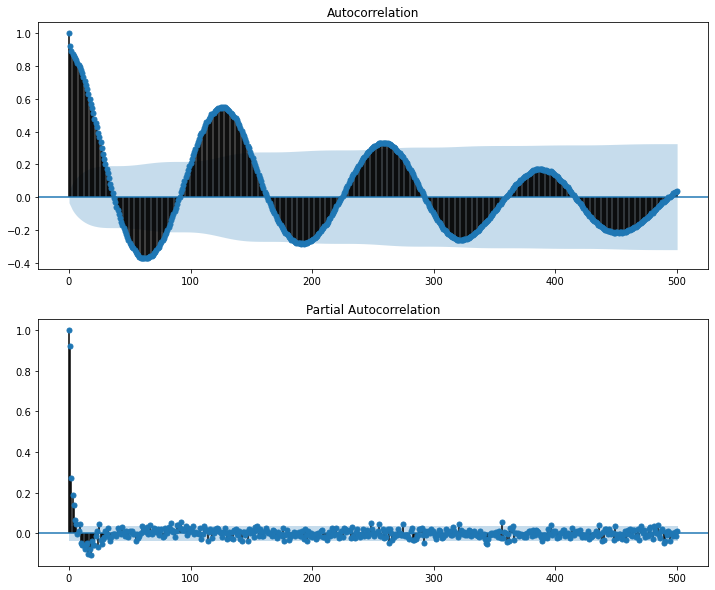

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


fig, ax = plt.subplots(2, figsize=(12,10))
ax[0] = plot_acf(df['Monthly sunspot number'], ax=ax[0], lags=500)
ax[1] = plot_pacf(df['Monthly sunspot number'], ax=ax[1], lags=500)

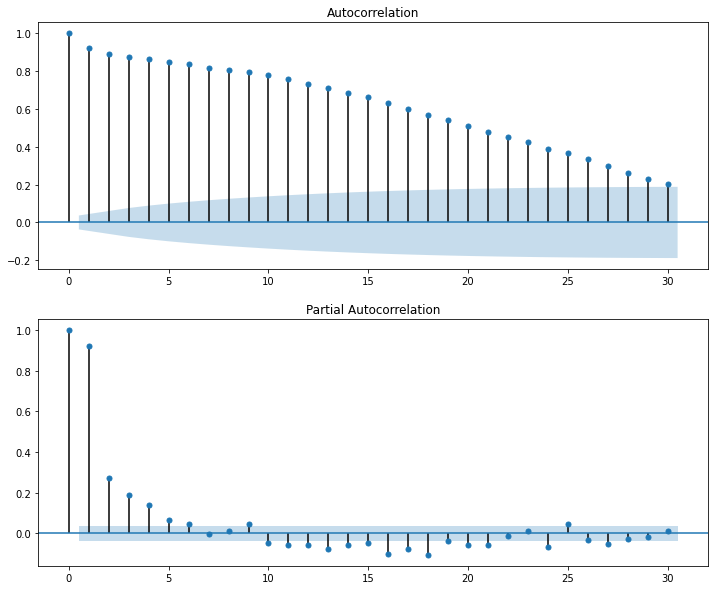

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


fig, ax = plt.subplots(2, figsize=(12,10))
ax[0] = plot_acf(df['Monthly sunspot number'], ax=ax[0], lags=30)
ax[1] = plot_pacf(df['Monthly sunspot number'], ax=ax[1], lags=30)

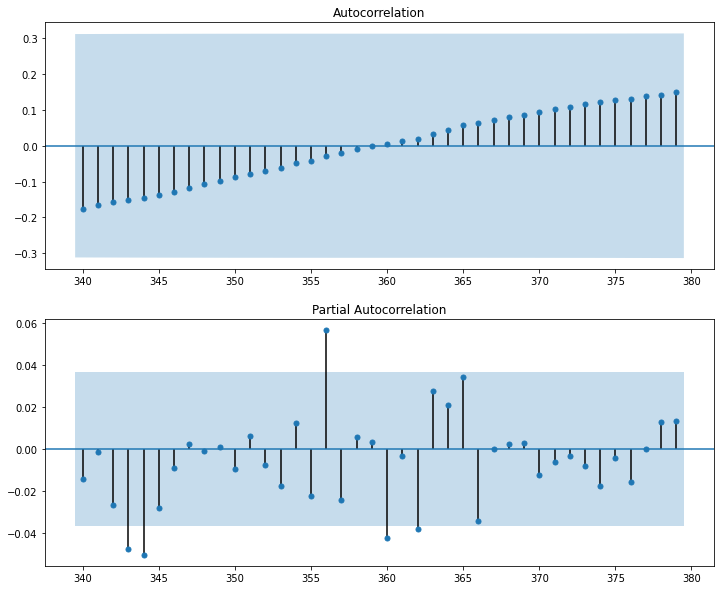

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


fig, ax = plt.subplots(2, figsize=(12,10))
ax[0] = plot_acf(df['Monthly sunspot number'], ax=ax[0], lags=range(340, 380))
ax[1] = plot_pacf(df['Monthly sunspot number'], ax=ax[1], lags=range(340, 380))

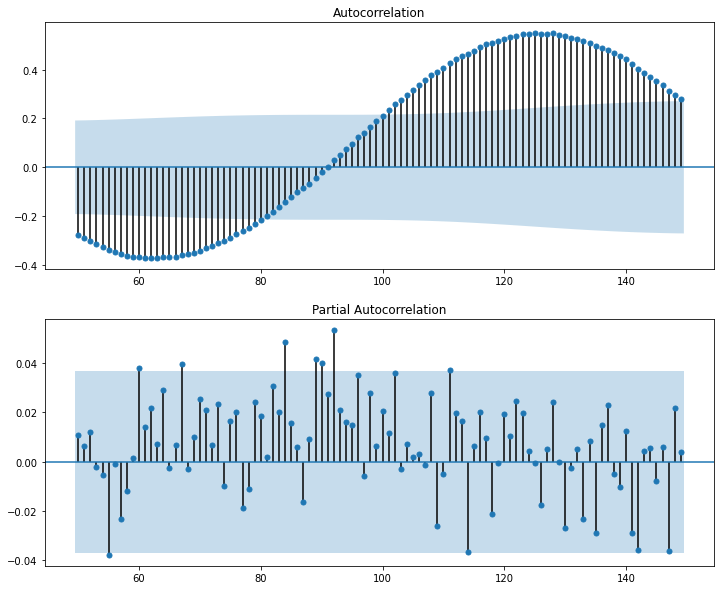

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


fig, ax = plt.subplots(2, figsize=(12,10))
ax[0] = plot_acf(df['Monthly sunspot number'], ax=ax[0], lags=range(50, 150))
ax[1] = plot_pacf(df['Monthly sunspot number'], ax=ax[1], lags=range(50, 150))

In [15]:
x = df[['Month', 'Monthly sunspot number']].copy().reset_index(drop=True)
x.head()

,Month,Monthly sunspot number
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


![%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5.png](attachment:%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5.png)

проверим

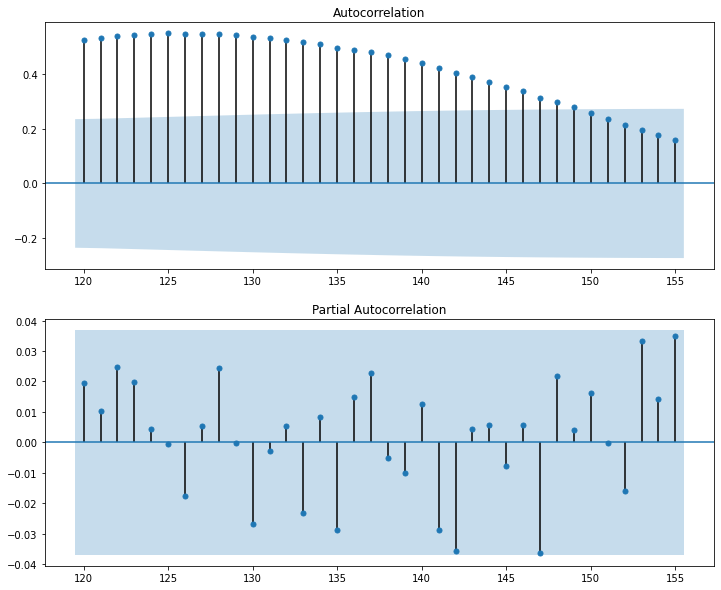

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


fig, ax = plt.subplots(2, figsize=(12,10))
ax[0] = plot_acf(df['Monthly sunspot number'], ax=ax[0], lags=range(10*12, 13*12))
ax[1] = plot_pacf(df['Monthly sunspot number'], ax=ax[1], lags=range(10*12, 13*12))

создадим лаг признаки на основе автоорелляции и частичной автокорелляции

In [17]:
for i in range(11):
    x[f'Sunspot_shifted_{i+1}'] = x['Monthly sunspot number'].shift(i+1)

In [18]:
for i in range(55, 65):
    x[f'Sunspot_shifted_{i+1}'] = x['Monthly sunspot number'].shift(i+1)

In [19]:
for i in range(120, 140):
    x[f'Sunspot_shifted_{i+1}'] = x['Monthly sunspot number'].shift(i+1)

In [20]:
for i in range(344, 348):
    x[f'Sunspot_shifted_{i+1}'] = x['Monthly sunspot number'].shift(i+1)

In [21]:
corr = x.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-21-482fc1f9b871>:2: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,Monthly sunspot number,Sunspot_shifted_1,Sunspot_shifted_2,Sunspot_shifted_3,Sunspot_shifted_4,Sunspot_shifted_5,Sunspot_shifted_6,Sunspot_shifted_7,Sunspot_shifted_8,Sunspot_shifted_9,Sunspot_shifted_10,Sunspot_shifted_11,Sunspot_shifted_56,Sunspot_shifted_57,Sunspot_shifted_58,Sunspot_shifted_59,Sunspot_shifted_60,Sunspot_shifted_61,Sunspot_shifted_62,Sunspot_shifted_63,Sunspot_shifted_64,Sunspot_shifted_65,Sunspot_shifted_121,Sunspot_shifted_122,Sunspot_shifted_123,Sunspot_shifted_124,Sunspot_shifted_125,Sunspot_shifted_126,Sunspot_shifted_127,Sunspot_shifted_128,Sunspot_shifted_129,Sunspot_shifted_130,Sunspot_shifted_131,Sunspot_shifted_132,Sunspot_shifted_133,Sunspot_shifted_134,Sunspot_shifted_135,Sunspot_shifted_136,Sunspot_shifted_137,Sunspot_shifted_138,Sunspot_shifted_139,Sunspot_shifted_140,Sunspot_shifted_345,Sunspot_shifted_346,Sunspot_shifted_347,Sunspot_shifted_348
Monthly sunspot number,1.00,0.92,0.89,0.87,0.86,0.85,0.84,0.82,0.81,0.80,0.78,0.76,-0.36,-0.37,-0.38,-0.39,-0.39,-0.39,-0.39,-0.39,-0.39,-0.39,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,0.53,0.52,0.51,0.50,0.48,0.47,-0.17,-0.16,-0.14,-0.13
Sunspot_shifted_1,0.92,1.00,0.92,0.89,0.87,0.86,0.85,0.84,0.82,0.81,0.80,0.78,-0.35,-0.36,-0.37,-0.38,-0.39,-0.39,-0.39,-0.39,-0.39,-0.39,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,0.53,0.52,0.51,0.50,0.48,-0.18,-0.17,-0.16,-0.14
Sunspot_shifted_2,0.89,0.92,1.00,0.92,0.89,0.87,0.86,0.85,0.84,0.82,0.81,0.80,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.39,-0.39,-0.39,-0.39,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,0.53,0.52,0.51,0.50,-0.19,-0.18,-0.17,-0.16
Sunspot_shifted_3,0.87,0.89,0.92,1.00,0.92,0.89,0.87,0.86,0.85,0.84,0.82,0.81,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.39,-0.39,-0.39,0.54,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,0.53,0.52,0.51,-0.19,-0.19,-0.18,-0.17
Sunspot_shifted_4,0.86,0.87,0.89,0.92,1.00,0.92,0.89,0.87,0.86,0.85,0.84,0.82,-0.31,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.39,-0.39,0.54,0.54,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,0.53,0.52,-0.20,-0.19,-0.19,-0.18
Sunspot_shifted_5,0.85,0.86,0.87,0.89,0.92,1.00,0.92,0.89,0.88,0.86,0.85,0.84,-0.30,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.39,0.52,0.54,0.54,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,0.53,-0.21,-0.20,-0.19,-0.19
Sunspot_shifted_6,0.84,0.85,0.86,0.87,0.89,0.92,1.00,0.92,0.89,0.87,0.86,0.85,-0.29,-0.30,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,0.51,0.52,0.54,0.54,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,-0.22,-0.21,-0.20,-0.19
Sunspot_shifted_7,0.82,0.84,0.85,0.86,0.87,0.89,0.92,1.00,0.92,0.89,0.88,0.86,-0.28,-0.29,-0.30,-0.32,-0.33,-0.34,-0.36,-0.36,-0.37,-0.38,0.50,0.51,0.52,0.54,0.54,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,-0.23,-0.22,-0.21,-0.20
Sunspot_shifted_8,0.81,0.82,0.84,0.85,0.86,0.88,0.89,0.92,1.00,0.92,0.89,0.88,-0.26,-0.28,-0.29,-0.31,-0.32,-0.33,-0.34,-0.36,-0.37,-0.37,0.49,0.50,0.51,0.52,0.54,0.54,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,-0.24,-0.23,-0.22,-0.21
Sunspot_shifted_9,0.80,0.81,0.82,0.84,0.85,0.86,0.87,0.89,0.92,1.00,0.92,0.89,-0.24,-0.26,-0.28,-0.29,-0.31,-0.32,-0.33,-0.34,-0.36,-0.37,0.47,0.49,0.50,0.51,0.52,0.54,0.54,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,-0.25,-0.24,-0.23,-0.22


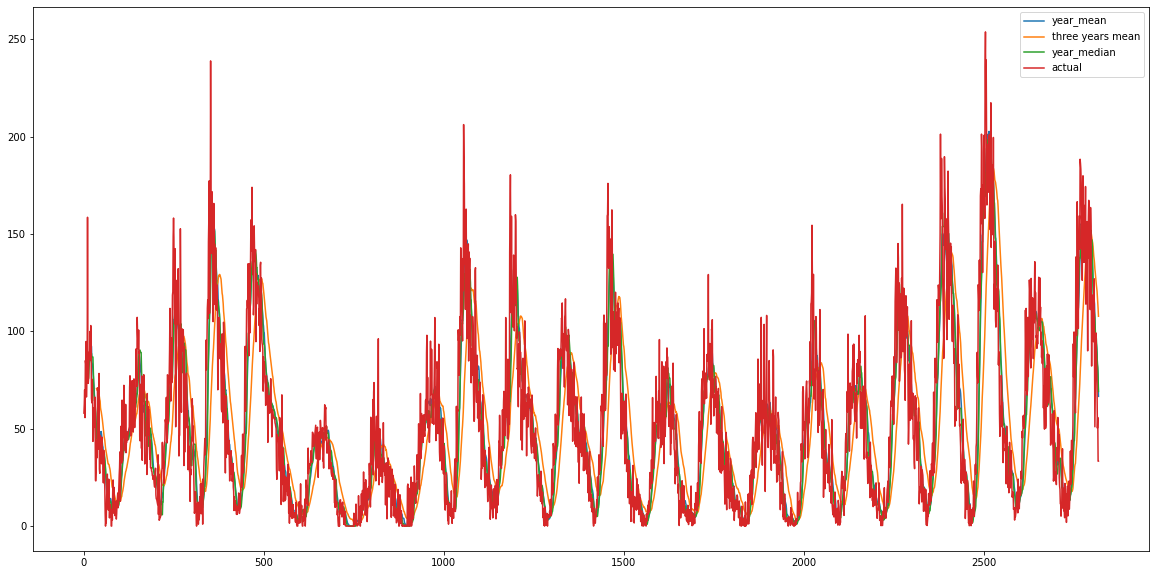

In [22]:
sub_data = df[['Month', 'Monthly sunspot number']].copy().reset_index(drop=True)
year_mean = sub_data['Monthly sunspot number'].rolling(12).apply(np.mean)
year_median = sub_data['Monthly sunspot number'].rolling(12).apply(np.median)
th_years_mean = sub_data['Monthly sunspot number'].rolling(36).apply(np.mean)
plt.figure(figsize=(20, 10))
year_mean.plot(label='year_mean')
th_years_mean.plot(label = "three years mean")
year_median.plot(label = "year_median")
sub_data['Monthly sunspot number'].plot(label='actual')
plt.legend()
pass

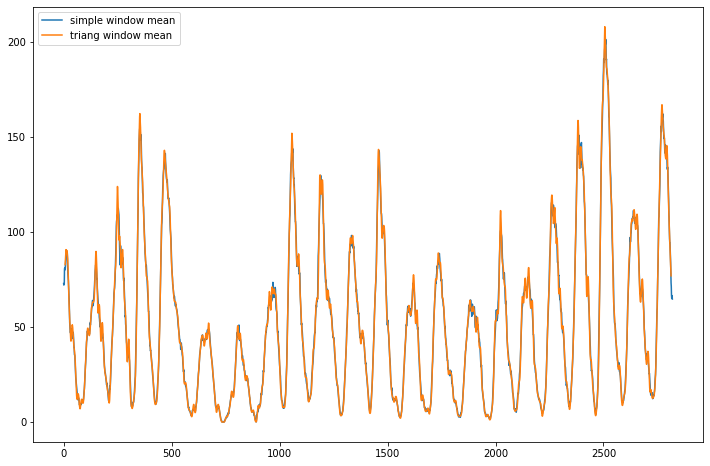

In [23]:
simple_window = sub_data['Monthly sunspot number'].rolling(
    14, center=True, min_periods=0
).apply(np.mean)
center_window = sub_data['Monthly sunspot number'].rolling(
    14, center=True, win_type='triang', min_periods=0
).mean()

plt.figure(figsize=(12, 8))
simple_window.plot(label='simple window mean')
center_window.plot(label='triang window mean')
plt.legend()
pass

In [24]:

def lin_regression(y: np.ndarray) -> np.ndarray:
    """Получить тренд массива"""
    x = np.arange(len(y))
    m_x = np.mean(x)
    m_y = np.mean(y)
    return np.sum((x - m_x) * (y - m_y)) / np.sum((x - m_x) ** 2)


def lin_regression_numpy(y: np.ndarray) -> np.ndarray:
    """Получить тренд массива"""
    x = np.arange(len(y))
    m_x = np.mean(x)
    m_y = np.mean(y)
    return np.sum((x - m_x) * (y - m_y)) / np.sum((x - m_x) ** 2)


def max_min_diff(x: np.ndarray) -> np.ndarray:
    x_min = np.min(x)
    x_max = np.max(x)
    return x_max - x_min


def max_min_diff_numpy(x: np.ndarray) -> np.ndarray:
    x_min = np.min(x)
    x_max = np.max(x)
    return x_max - x_min

In [25]:
window = 3

x['sunspot_shifted_1_max_min_3_month'] = x['Sunspot_shifted_1'].rolling(
    window
).apply(
    lambda x: max_min_diff_numpy(x.to_numpy())
)
x['sunspot_shifted_1_trend_3_month'] = x['Sunspot_shifted_1'].rolling(
    window
).apply(
    lambda x: lin_regression_numpy(x.to_numpy())
)
x['sunspot_shifted_1_mean_3_month'] = x['Sunspot_shifted_1'].rolling(
    window
).apply(
    np.mean)
x['sunspot_shifted_1_median_3_month'] = x['Sunspot_shifted_1'].rolling(
    window
).apply(
    np.median)


In [26]:
window = 2
shift = 12*11

x[f'Sunspot_shifted_{shift}_mean_2_month'] = x[f'Sunspot_shifted_{shift}'].rolling(
    window, center=True
).apply(np.mean)
x[f'Sunspot_shifted_{shift}_std_2_month'] = x[f'Sunspot_shifted_{shift}'].rolling(
    window, center=True
).apply(np.std)
x[f'Sunspot_shifted_{shift}_median_2_month'] = x[f'Sunspot_shifted_{shift}'].rolling(
    window, center=True
).apply(np.median)

x[f'Sunspot_shifted_{shift}_max_min_2_month'] = x[f'Sunspot_shifted_{shift}'].rolling(
    window, center=True
).apply(lambda x: max_min_diff(x.to_numpy()))
x[f'Sunspot_shifted_{shift}_trend_1_week'] = x[f'Sunspot_shifted_{shift}'].rolling(
    window, center=True
).apply(lambda x: lin_regression(x.to_numpy()))

In [27]:
corr = x.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-27-482fc1f9b871>:2: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,Monthly sunspot number,Sunspot_shifted_1,Sunspot_shifted_2,Sunspot_shifted_3,Sunspot_shifted_4,Sunspot_shifted_5,Sunspot_shifted_6,Sunspot_shifted_7,Sunspot_shifted_8,Sunspot_shifted_9,Sunspot_shifted_10,Sunspot_shifted_11,Sunspot_shifted_56,Sunspot_shifted_57,Sunspot_shifted_58,Sunspot_shifted_59,Sunspot_shifted_60,Sunspot_shifted_61,Sunspot_shifted_62,Sunspot_shifted_63,Sunspot_shifted_64,Sunspot_shifted_65,Sunspot_shifted_121,Sunspot_shifted_122,Sunspot_shifted_123,Sunspot_shifted_124,Sunspot_shifted_125,Sunspot_shifted_126,Sunspot_shifted_127,Sunspot_shifted_128,Sunspot_shifted_129,Sunspot_shifted_130,Sunspot_shifted_131,Sunspot_shifted_132,Sunspot_shifted_133,Sunspot_shifted_134,Sunspot_shifted_135,Sunspot_shifted_136,Sunspot_shifted_137,Sunspot_shifted_138,Sunspot_shifted_139,Sunspot_shifted_140,Sunspot_shifted_345,Sunspot_shifted_346,Sunspot_shifted_347,Sunspot_shifted_348,sunspot_shifted_1_max_min_3_month,sunspot_shifted_1_trend_3_month,sunspot_shifted_1_mean_3_month,sunspot_shifted_1_median_3_month,Sunspot_shifted_132_mean_2_month,Sunspot_shifted_132_std_2_month,Sunspot_shifted_132_median_2_month,Sunspot_shifted_132_max_min_2_month,Sunspot_shifted_132_trend_1_week
Monthly sunspot number,1.00,0.92,0.89,0.87,0.86,0.85,0.84,0.82,0.81,0.80,0.78,0.76,-0.36,-0.37,-0.38,-0.39,-0.39,-0.39,-0.39,-0.39,-0.39,-0.39,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,0.53,0.52,0.51,0.50,0.48,0.47,-0.17,-0.16,-0.14,-0.13,0.55,0.10,0.92,0.92,0.57,0.27,0.57,0.27,0.03
Sunspot_shifted_1,0.92,1.00,0.92,0.89,0.87,0.86,0.85,0.84,0.82,0.81,0.80,0.78,-0.35,-0.36,-0.37,-0.38,-0.39,-0.39,-0.39,-0.39,-0.39,-0.39,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,0.53,0.52,0.51,0.50,0.48,-0.18,-0.17,-0.16,-0.14,0.57,0.23,0.97,0.96,0.57,0.29,0.57,0.29,0.01
Sunspot_shifted_2,0.89,0.92,1.00,0.92,0.89,0.87,0.86,0.85,0.84,0.82,0.81,0.80,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.39,-0.39,-0.39,-0.39,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,0.53,0.52,0.51,0.50,-0.19,-0.18,-0.17,-0.16,0.57,-0.00,0.98,0.98,0.58,0.28,0.58,0.28,0.01
Sunspot_shifted_3,0.87,0.89,0.92,1.00,0.92,0.89,0.87,0.86,0.85,0.84,0.82,0.81,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.39,-0.39,-0.39,0.54,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,0.53,0.52,0.51,-0.19,-0.19,-0.18,-0.17,0.56,-0.23,0.97,0.96,0.59,0.28,0.59,0.28,0.02
Sunspot_shifted_4,0.86,0.87,0.89,0.92,1.00,0.92,0.89,0.87,0.86,0.85,0.84,0.82,-0.31,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.39,-0.39,0.54,0.54,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,0.53,0.52,-0.20,-0.19,-0.19,-0.18,0.53,-0.10,0.92,0.92,0.59,0.28,0.59,0.28,0.01
Sunspot_shifted_5,0.85,0.86,0.87,0.89,0.92,1.00,0.92,0.89,0.88,0.86,0.85,0.84,-0.30,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.39,0.52,0.54,0.54,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,0.53,-0.21,-0.20,-0.19,-0.19,0.51,-0.06,0.90,0.90,0.60,0.28,0.60,0.28,-0.00
Sunspot_shifted_6,0.84,0.85,0.86,0.87,0.89,0.92,1.00,0.92,0.89,0.87,0.86,0.85,-0.29,-0.30,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,0.51,0.52,0.54,0.54,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,0.54,-0.22,-0.21,-0.20,-0.19,0.50,-0.05,0.89,0.88,0.60,0.29,0.60,0.29,-0.00
Sunspot_shifted_7,0.82,0.84,0.85,0.86,0.87,0.89,0.92,1.00,0.92,0.89,0.88,0.86,-0.28,-0.29,-0.30,-0.32,-0.33,-0.34,-0.36,-0.36,-0.37,-0.38,0.50,0.51,0.52,0.54,0.54,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,0.55,-0.23,-0.22,-0.21,-0.20,0.50,-0.06,0.88,0.87,0.60,0.29,0.60,0.29,0.00
Sunspot_shifted_8,0.81,0.82,0.84,0.85,0.86,0.88,0.89,0.92,1.00,0.92,0.89,0.88,-0.26,-0.28,-0.29,-0.31,-0.32,-0.33,-0.34,-0.36,-0.37,-0.37,0.49,0.50,0.51,0.52,0.54,0.54,0.55,0.56,0.57,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.56,-0.24,-0.23,-0.22,-0.21,0.49,-0.07,0.86,0.86,0.60,0.29,0.60,0.29,-0.00
Sunspot_shifted_9,0.80,0.81,0

In [28]:
backup = x.copy()
x = x.dropna()
y = x['Monthly sunspot number']
del x['Monthly sunspot number']

In [31]:
split_train_size = 0.7
split_val_size = 0.85

dates = pd.to_datetime(x['Month'])
train_quantile = dates.quantile(split_train_size)
val_quantile = dates.quantile(split_val_size)

x_train = x[dates < train_quantile]
y_train = y[dates < train_quantile]

x_val = x[(dates >= train_quantile) & (dates < val_quantile)]
y_val = y[(dates >= train_quantile) & (dates < val_quantile)]

x_test = x[dates > val_quantile]
y_test = y[dates > val_quantile]

print(f'Train      from {x_train.Month.min()} to {x_train.Month.max()}')
print(f'Validation from {x_val.Month.min()} to {x_val.Month.max()}')
print(f'Test       from {x_test.Month.min()} to {x_test.Month.max()}')

del x_train['Month']
del x_val['Month']
del x_test['Month']

Train      from 1778-01 to 1922-02
Validation from 1922-03 to 1953-01
Test       from 1953-02 to 1983-12


In [32]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'reg_lambda': [0, 0.1, 0.2]
}

# Create the XGBRegressor model
model = xgb.XGBRegressor()

# Create the grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print(f'Best hyperparameters: {grid_search.best_params_}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[13:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 0.2}


In [33]:

model = xgb.XGBRegressor(**grid_search.best_params_)


In [34]:
model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=10)


[13:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:65.8129
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:59.9808
[2]	validation_0-rmse:54.8658
[3]	validation_0-rmse:50.1358
[4]	validation_0-rmse:45.9605
[5]	validation_0-rmse:42.3697
[6]	validation_0-rmse:39.098
[7]	validation_0-rmse:36.184
[8]	validation_0-rmse:33.6472
[9]	validation_0-rmse:31.4209
[10]	validation_0-rmse:29.4688
[11]	validation_0-rmse:27.8593
[12]	validation_0-rmse:26.3434
[13]	validation_0-rmse:25.0679
[14]	validation_0-rmse:23.9144
[15]	validation_0-rmse:22.9446
[16]	validation_0-rmse:22.1089
[17]	validation_0-rmse:21.4583
[18]	validation_0-rmse:20.7645
[19]	validation_0-rmse:20.2453
[20]	validation_0-rmse:19.83
[21]	validation_0-rmse:19.4427
[22]	validation_0-rmse:19.1655
[23]	validation_0-rmse:18.8421
[24]	validation_0-rmse:18.5965
[25]	validation_0-rmse:18.3443
[26]	validation_

XGBRegressor(reg_lambda=0.2)

In [35]:
y_pred = model.predict(x_test)

# Calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

Mean squared error: 506.48255581480976


In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [38]:


# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute error: {mae:.2f}')

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root mean squared error: {rmse:.2f}')

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)
print(f'R-squared score: {r2:.2f}')

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"mape: {mape}")



Mean absolute error: 16.16
Root mean squared error: 22.51
R-squared score: 0.85
mape: 0.529787839393731


In [39]:
split_train_size = 0.7
split_val_size = 0.85

dates = pd.to_datetime(x['Month'])
train_quantile = dates.quantile(split_train_size)
val_quantile = dates.quantile(split_val_size)

x_train = x[dates < train_quantile]
y_train = y[dates < train_quantile]

x_val = x[(dates >= train_quantile) & (dates < val_quantile)]
y_val = y[(dates >= train_quantile) & (dates < val_quantile)]

x_test = x[dates > val_quantile]
y_test = y[dates > val_quantile]

print(f'Train      from {x_train.Month.min()} to {x_train.Month.max()}')
print(f'Validation from {x_val.Month.min()} to {x_val.Month.max()}')
print(f'Test       from {x_test.Month.min()} to {x_test.Month.max()}')

del x_train['Month']
del x_val['Month']
del x_test['Month']

Train      from 1778-01 to 1922-02
Validation from 1922-03 to 1953-01
Test       from 1953-02 to 1983-12


In [40]:
import lightgbm as lgb


In [41]:
train_mat = lgb.Dataset(x_train, label=y_train)
val_mat = lgb.Dataset(x_val, label=y_val)

params = {
    'metric': 'mse', 
    'objective': 'mse', 
    'feature_fraction': 1,
    'learning_rate': 0.01,
    'force_row_wise': True
}

model = lgb.train(
    params,
    train_mat,
    valid_sets=[train_mat, val_mat],
    num_boost_round=1000,
    verbose_eval=50,
    early_stopping_rounds=100
)

all_mse = mean_squared_error(y_test, model.predict(x_test))
feats_importance = model.feature_importance()

Training until validation scores don't improve for 100 rounds.
[50]	training's l2: 641.666	valid_1's l2: 1055.36
[100]	training's l2: 319.539	valid_1's l2: 621.692
[150]	training's l2: 188.875	valid_1's l2: 438.76
[200]	training's l2: 130.834	valid_1's l2: 367.587
[250]	training's l2: 101.528	valid_1's l2: 336.83
[300]	training's l2: 83.4159	valid_1's l2: 327.023
[350]	training's l2: 70.6146	valid_1's l2: 319.072
[400]	training's l2: 61.0604	valid_1's l2: 316.285
[450]	training's l2: 53.2243	valid_1's l2: 313.634
[500]	training's l2: 47.0048	valid_1's l2: 313.763
Early stopping, best iteration is:
[448]	training's l2: 53.5334	valid_1's l2: 313.441


In [42]:
good_feats = list(corr[corr['Monthly sunspot number'] > 0.5].index.values)
good_feats.remove('Monthly sunspot number')

train_mat = lgb.Dataset(x_train[good_feats], label=y_train)
val_mat = lgb.Dataset(x_val[good_feats], label=y_val)

params = {
    'metric': 'mse', 
    'objective': 'mse', 
    'feature_fraction': 1,
    'learning_rate': 0.01,
    'force_row_wise': True
}

model2 = lgb.train(
    params,
    train_mat,
    valid_sets=[train_mat, val_mat],
    num_boost_round=1000,
    verbose_eval=50,
    early_stopping_rounds=100
)

only_good_mse = mean_squared_error(y_test, model2.predict(x_test[good_feats]))

Training until validation scores don't improve for 100 rounds.
[50]	training's l2: 645.442	valid_1's l2: 1031.96
[100]	training's l2: 326.177	valid_1's l2: 590.07
[150]	training's l2: 196.722	valid_1's l2: 415.376
[200]	training's l2: 139.562	valid_1's l2: 343.427
[250]	training's l2: 110.6	valid_1's l2: 313.33
[300]	training's l2: 92.5169	valid_1's l2: 301.987
[350]	training's l2: 79.7453	valid_1's l2: 295.482
[400]	training's l2: 70.3222	valid_1's l2: 293.661
[450]	training's l2: 62.8101	valid_1's l2: 292.229
[500]	training's l2: 56.7406	valid_1's l2: 291.163
[550]	training's l2: 51.7372	valid_1's l2: 289.411
[600]	training's l2: 47.3764	valid_1's l2: 289.918
[650]	training's l2: 43.4224	valid_1's l2: 290.059
Early stopping, best iteration is:
[554]	training's l2: 51.3753	valid_1's l2: 289.366


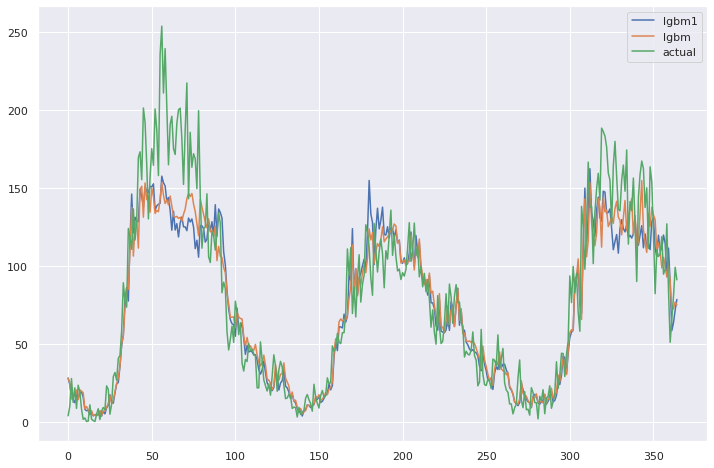

In [43]:
sns.set(font_scale=1)
size = 365
plt.figure(figsize=(12, 8))
plt.plot(model.predict(x_test)[:size], label='lgbm1')
plt.plot(model2.predict(x_test[good_feats])[:size], label='lgbm')
plt.plot(y_test.reset_index(drop=True)[:size], label='actual')
plt.legend()
plt.show()

In [45]:
print('All features MSE:      ', round(all_mse, 5))
print('Only good features MSE:', round(only_good_mse, 5))

All features MSE:       629.92583
Only good features MSE: 562.86205


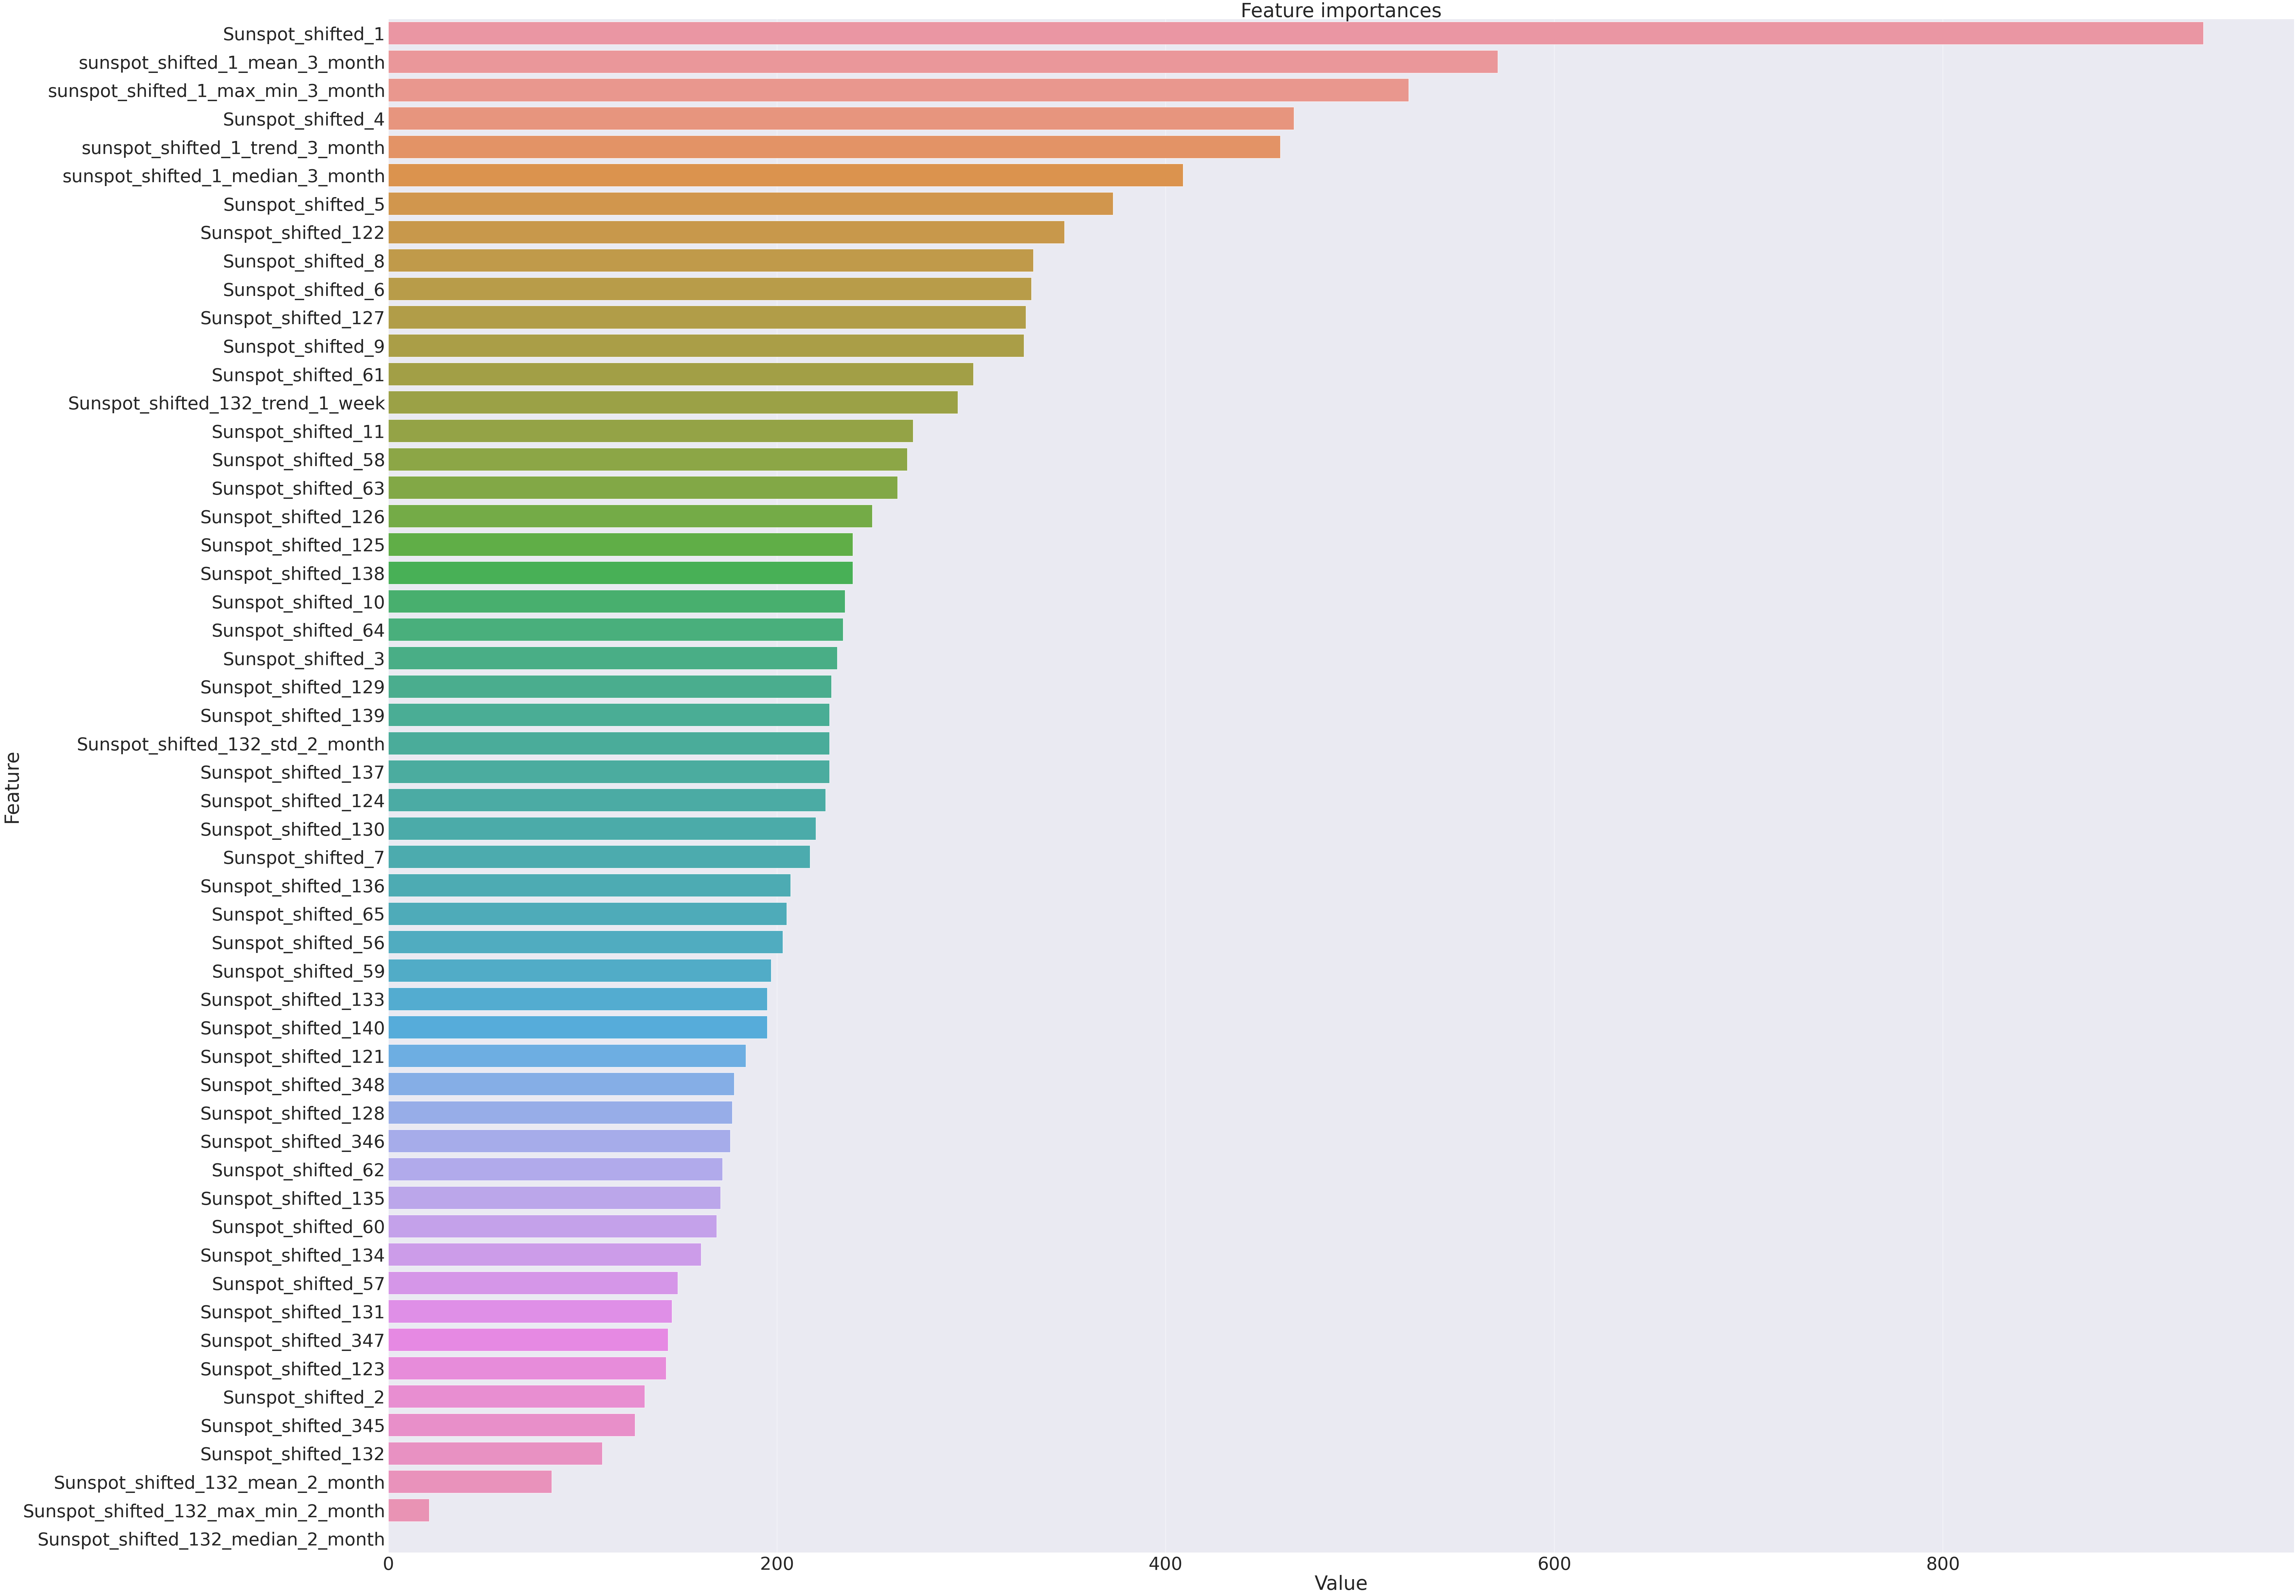

In [46]:
def plot_importance(importances) -> None:
    feature_imp = pd.DataFrame({'Value': importances, 'Feature': x_train.columns})

    plt.figure(figsize=(100, 70))
    sns.set(font_scale=5)
    sns_plot = sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values('Value', ascending=False))
    plt.title(f'Feature importances')
    plt.tight_layout()
    sns_plot = sns_plot.get_figure()
    
plot_importance(feats_importance)

In [47]:
good_feats = x_train.columns[np.argsort(feats_importance)[-25:]]

train_mat = lgb.Dataset(x_train[good_feats], label=y_train)
val_mat = lgb.Dataset(x_val[good_feats], label=y_val)

params = {
    'metric': 'mse', 
    'objective': 'mse', 
    'feature_fraction': 1,
    'learning_rate': 0.01,
    'force_row_wise': True
}

model = lgb.train(
    params,
    train_mat,
    valid_sets=[train_mat, val_mat],
    num_boost_round=1000,
    verbose_eval=50,
    early_stopping_rounds=100
)

only_good_by_imp_mse = mean_squared_error(y_test, model.predict(x_test[good_feats]))

Training until validation scores don't improve for 100 rounds.
[50]	training's l2: 642.783	valid_1's l2: 1051.06
[100]	training's l2: 322.319	valid_1's l2: 612.496
[150]	training's l2: 193.619	valid_1's l2: 436.743
[200]	training's l2: 136.559	valid_1's l2: 367.327
[250]	training's l2: 108.14	valid_1's l2: 338.41
[300]	training's l2: 90.3228	valid_1's l2: 322.848
[350]	training's l2: 77.8467	valid_1's l2: 317.63
[400]	training's l2: 68.47	valid_1's l2: 313.862
[450]	training's l2: 60.8487	valid_1's l2: 312.12
[500]	training's l2: 54.968	valid_1's l2: 311.76
[550]	training's l2: 50.2173	valid_1's l2: 313.059
Early stopping, best iteration is:
[485]	training's l2: 56.5765	valid_1's l2: 311.26


отобрали хорошие фичи и получили что-то более менее

In [48]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

Train      from 1778-01 to 1922-02
Test       from 1922-03 to 1983-12
Mean absolute error: 14.31
Root mean squared error: 19.74
R-squared score: 0.86
mape: 0.5646393452212712
Mean squared error: 389.8031255437987


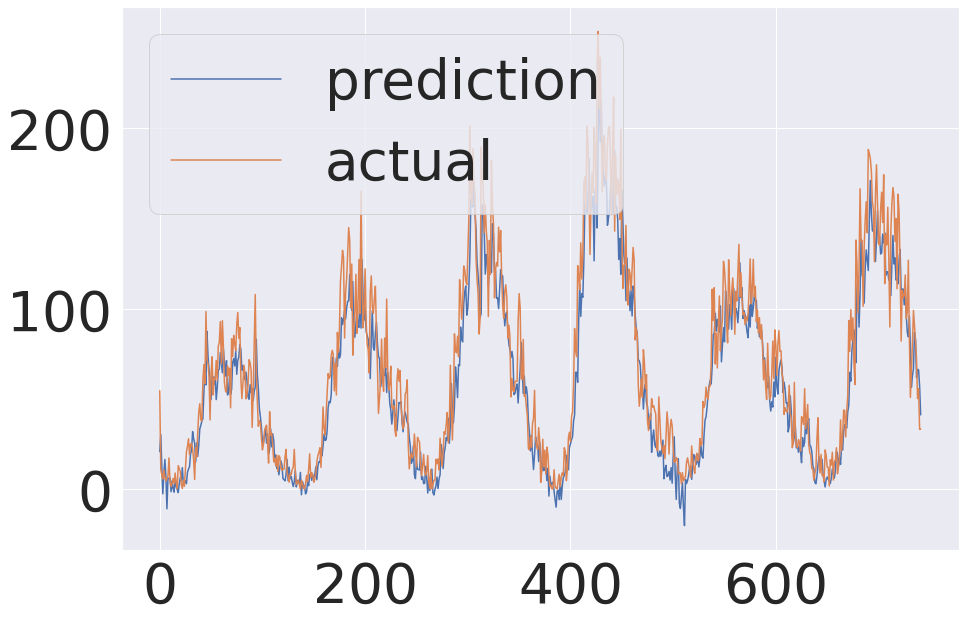

In [49]:
plit_train_size = 0.7

dates = pd.to_datetime(x['Month'])

train_quantile = dates.quantile(split_train_size)

x_train = x[dates < train_quantile]
y_train = y[dates < train_quantile]

x_test = x[dates > train_quantile]
y_test = y[dates > train_quantile]

print(f'Train      from {x_train.Month.min()} to {x_train.Month.max()}')
print(f'Test       from {x_test.Month.min()} to {x_test.Month.max()}')

del x_train['Month']
del x_test['Month']

regr = MLPRegressor(random_state=1, max_iter=500).fit(x_train, y_train)
pred = regr.predict(x_test)
# Calculate the mean absolute error
mae = mean_absolute_error(y_test, pred)
print(f'Mean absolute error: {mae:.2f}')

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Root mean squared error: {rmse:.2f}')

# Calculate the R-squared score
r2 = r2_score(y_test, pred)
print(f'R-squared score: {r2:.2f}')

mape = mean_absolute_percentage_error(y_test, pred)
print(f"mape: {mape}")

mse = mean_squared_error(y_test, pred)
print(f'Mean squared error: {mse}')

plt.figure(figsize=(15, 10))
plt.plot(pred, label = 'prediction')
plt.plot(np.array(y_test), label = 'actual')
plt.legend()

есть предположение если обучать только на хороших фичах. то будет лучше

In [50]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout

In [51]:
model = Sequential()
model.add(Conv1D(16, 2, activation="relu", input_shape=(54, 1)))
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 53, 16)            48        
                                                                 
 flatten (Flatten)           (None, 848)               0         
                                                                 
 dense (Dense)               (None, 16)                13584     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 13,649
Trainable params: 13,649
Non-trainable params: 0
_________________________________________________________________


In [56]:
split_train_size = 0.7
split_val_size = 0.85

dates = pd.to_datetime(x['Month'])
train_quantile = dates.quantile(split_train_size)
val_quantile = dates.quantile(split_val_size)

x_train = x[dates < train_quantile]
y_train = y[dates < train_quantile]

x_val = x[(dates >= train_quantile) & (dates < val_quantile)]
y_val = y[(dates >= train_quantile) & (dates < val_quantile)]

x_test = x[dates > val_quantile]
y_test = y[dates > val_quantile]

print(f'Train      from {x_train.Month.min()} to {x_train.Month.max()}')
print(f'Validation from {x_val.Month.min()} to {x_val.Month.max()}')
print(f'Test       from {x_test.Month.min()} to {x_test.Month.max()}')

del x_train['Month']
del x_val['Month']
del x_test['Month']

Train      from 1778-01 to 1922-02
Validation from 1922-03 to 1953-01
Test       from 1953-02 to 1983-12


In [60]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=12, epochs=200, verbose=0)

In [64]:
pred = model.predict(x_test)

12/12 [==============================] - 0s 3ms/step


In [65]:
mae = mean_absolute_error(y_test, pred)
print(f'Mean absolute error: {mae:.2f}')

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Root mean squared error: {rmse:.2f}')

# Calculate the R-squared score
r2 = r2_score(y_test, pred)
print(f'R-squared score: {r2:.2f}')

mape = mean_absolute_percentage_error(y_test, pred)
print(f"mape: {mape}")

mse = mean_squared_error(y_test, pred)
print(f'Mean squared error: {mse}')

Mean absolute error: 20.32
Root mean squared error: 27.07
R-squared score: 0.78
mape: 0.7610004651140815
Mean squared error: 732.9149094041484


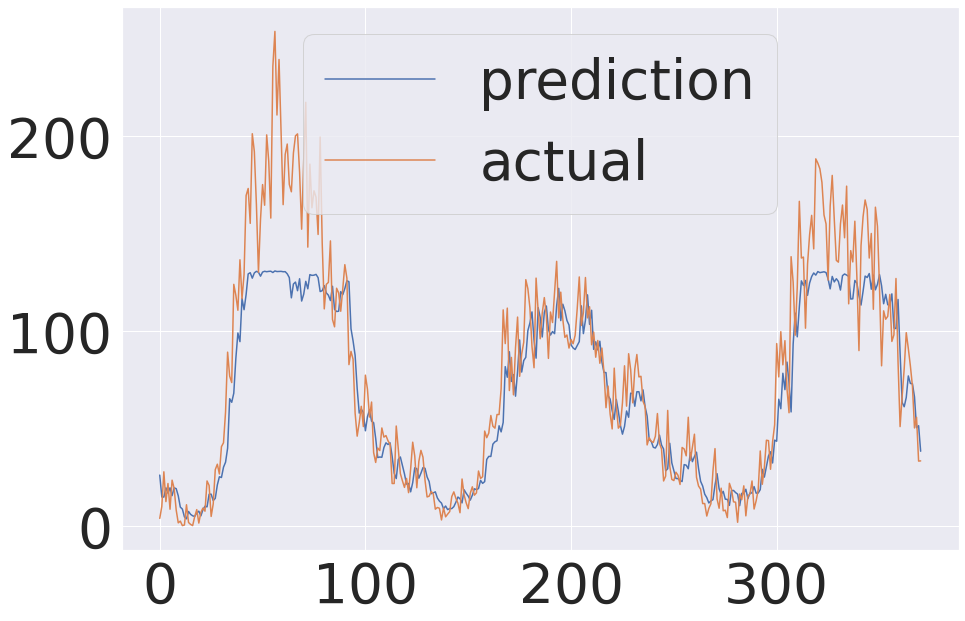

In [71]:
plt.figure(figsize=(15, 10))
plt.plot(pred, label = 'prediction')
plt.plot(np.array(y_test), label = 'actual')
plt.legend()

https://towardsdatascience.com/lstm-and-bidirectional-lstm-for-regression-4fddf910c655

In [67]:
from keras.layers import LSTM, Bidirectional

In [68]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(54, 1)))
model.add(Dropout(0.5))
model.add(LSTM(20, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 54, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 54, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                6800      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 23,717
Trainable params: 23,717
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=12, epochs=200, verbose=0)

In [70]:
pred = model.predict(x_test)

12/12 [==============================] - 1s 10ms/step


In [72]:
mae = mean_absolute_error(y_test, pred)
print(f'Mean absolute error: {mae:.2f}')

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Root mean squared error: {rmse:.2f}')

# Calculate the R-squared score
r2 = r2_score(y_test, pred)
print(f'R-squared score: {r2:.2f}')

mape = mean_absolute_percentage_error(y_test, pred)
print(f"mape: {mape}")

mse = mean_squared_error(y_test, pred)
print(f'Mean squared error: {mse}')

Mean absolute error: 17.97
Root mean squared error: 26.44
R-squared score: 0.79
mape: 0.5858214580558841
Mean squared error: 699.2116006586507


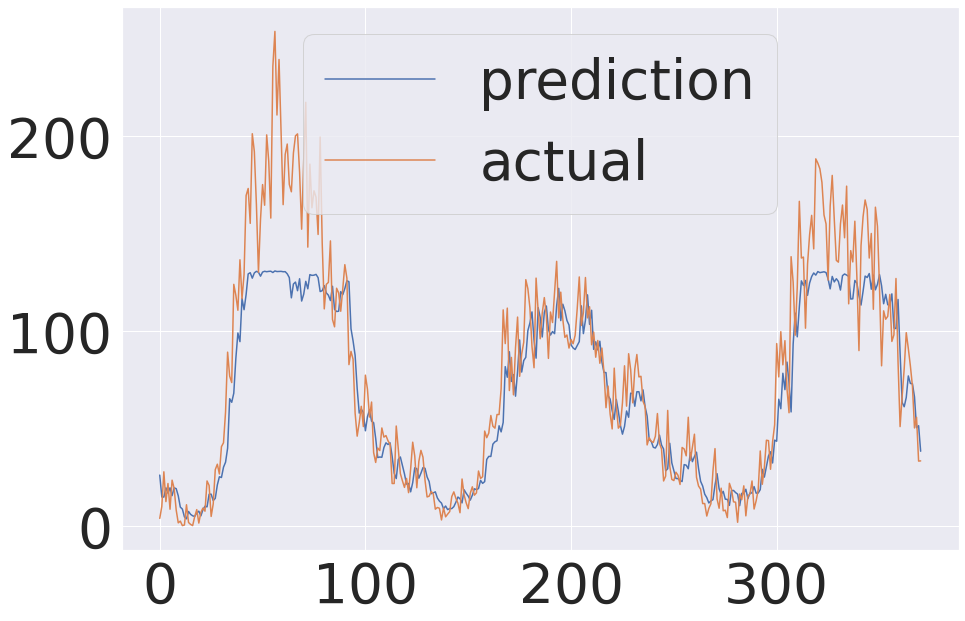

In [73]:
plt.figure(figsize=(15, 10))
plt.plot(pred, label = 'prediction')
plt.plot(np.array(y_test), label = 'actual')
plt.legend()

во всех случаях достаточно большое mse, что так себе. лучший результат показали simple nn. Так же они единственные предсказали первый большой всплеск